## 4.1 Topological Ordering of Animal Species

In [ ]:
import numpy as np
from google.colab import drive


drive.mount('/content/drive')

# Animal attributes: Each row contains the attributes of one animal
file_path = '/content/drive/MyDrive/DD2437_Lab2_data/animals.dat'

# Animal names: Names in the same order
names_path = '/content/drive/MyDrive/DD2437_Lab2_data/animalnames.txt'


props = np.loadtxt(file_path, delimiter=',')

# Each row contains the attributes of one animal
props = props.reshape(32, 84)

# Loading animal names
with open(names_path, 'r') as f:
    animal_names = [line.strip() for line in f]


print(f'Attributes shape: {props.shape}')  # Should be (32, 84) if correct
print(f'Number of animals: {len(animal_names)}')  # Should be 32

# print(props)
# print(animal_names)

Mounted at /content/drive
Attributes shape: (32, 84)
Number of animals: 32


In [ ]:
class SOM_animals:
    def __init__(self, num_nodes, input_dim, learning_rate=0.2, sigma=50, num_epochs=20):
        """
        Initializes the SOM with a 1D topology.

        :param num_nodes: Number of nodes (size of 1D output)
        :param input_dim: Dimension of each input vector
        :param learning_rate: Initial learning rate
        :param sigma: Initial neighborhood radius
        :param num_epochs: Number of training epochs
        """
        self.num_nodes = num_nodes
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.num_epochs = num_epochs
        # Calculate time constant for exponential decay of the neighborhood
        self.time_constant = num_epochs / np.log(self.sigma)

        # Initialize weights with random values between 0 and 1
        self.weights = np.random.rand(num_nodes, input_dim) # Shape 100 x 84

    def _euclidean_distance(self, x, y):
        """Compute Euclidean distance between two vectors."""
        return np.linalg.norm(x - y)

    def _find_bmu(self, input_vector):
        """
        Find the Best Matching Unit (BMU) for a given input vector.

        :param input_vector: The current animal's attribute vector
        :return: The index of the BMU (closest node)
        """
        # Calculating between two vectors and finding the weight of the difference vector
        distances = np.linalg.norm(self.weights - input_vector, axis=1)
        bmu_index = np.argmin(distances)
        return bmu_index # Index of winning node

    def _update_weights(self, input_vector, bmu_index, iteration):
        """
        Update the weights of the BMU and its neighbors.

        :param input_vector: The current animal's attribute vector
        :param bmu_index: Index of the BMU
        :param iteration: Current epoch number
        """
        # Decay the learning rate and sigma over time (dont know if necessary)
        #lr = self.learning_rate * (1 - iteration / self.num_epochs)


        # Decreasing sigma from 50 to end up close to one or zero:
        # sigma_t = self.sigma * (1 - iteration / self.num_epochs)

        # Decay neighborhood size over time (exponential decay)
        sigma_t = self.sigma * np.exp(-iteration / self.time_constant)
        lr = self.learning_rate # Fixed to 0.2

        for i in range(self.num_nodes):
            # Calculate the distance between the node and the BMU in 1D space
            distance_to_bmu = np.abs(i - bmu_index)

            # Update if the node is within the neighborhood radius
            if distance_to_bmu <= sigma_t:
                # Calculate influence (neighborhood function)
                influence = np.exp(-(distance_to_bmu ** 2) / (2 * sigma_t ** 2))

                # Update the weights of the node
                self.weights[i, :] += lr * influence * (input_vector - self.weights[i, :])

    def train(self, data):
        """
        Train the SOM network.

        :param data: The dataset of animal attributes (32 x 84)
        """

        # Outer loop for the epochs
        for epoch in range(self.num_epochs):
            print(f'Epoch {epoch + 1}/{self.num_epochs}')

            # Inner loop for looping through the 32 animals one at a time
            for i, input_vector in enumerate(data):
                # Find the Best Matching Unit (BMU)
                bmu_index = self._find_bmu(input_vector)

                # Update the BMU's weights and its neighbors
                self._update_weights(input_vector, bmu_index, epoch)

    def map_animals(self, data):
        """
        Map each animal's attribute vector to its corresponding BMU.

        :param data: The dataset of animal attributes (32 x 84)
        :return: A list of BMU indices corresponding to each animal
        """
        mapping = []
        for input_vector in data:
            bmu_index = self._find_bmu(input_vector)
            mapping.append(bmu_index)
        return mapping

    def sort_animals_by_bmu(self, animal_data, animal_names):

        # Step 1: Initialize the `pos` vector to store BMU indices for each animal
        pos = np.zeros(len(animal_data), dtype=int)

        # Step 2: Loop through each animal, calculate BMU, and store BMU index in `pos`
        for i, animal in enumerate(animal_data):
            bmu_index = self._find_bmu(animal)  # Use self to access class methods
            pos[i] = bmu_index

        # Step 3: Sort the indices based on BMU positions
        sorted_indices = np.argsort(pos)
        sorted_animals = [animal_names[i] for i in sorted_indices]

        # Step 4: Print animals in the sorted order
        print("Animals in natural order based on BMU indices:")
        for i in sorted_indices:
            print(f'Animal: {animal_names[i]}, BMU: {pos[i]}')

        return sorted_animals

    def get_weights(self):
        """Return the SOM weight matrix."""
        return self.weights

    # # If we want to use a trained model
    # def save_weights(self, file_name):
    #     np.save(file_name, self.weights)

    # def load_weights(self, file_name):
    #     self.weights = np.load(file_name)

In [ ]:
# Assuming props contains the 32x84 animal attribute matrix
# and animal_names contains the list of 32 animal names

# Initializing SOM
som = SOM_animals(num_nodes=100, input_dim=84, learning_rate=0.2, sigma=50, num_epochs=20)

print("Weight matrix size: ", som.weights.shape)
print("First 10 values of weights for testing: ", som.weights[0][:10])

# Training
som.train(props)

# Map each animal to a node in the 1D SOM
animal_mapping = som.map_animals(props)

# Print the mapping of animals to nodes
for i, animal in enumerate(animal_names):
    print(f'{animal} mapped to node {animal_mapping[i]}')

Weight matrix size:  (100, 84)
First 10 values of weights for testing:  [0.5175616  0.85811926 0.73006798 0.34899069 0.09831498 0.97357859
 0.70245415 0.70382981 0.66445088 0.98767554]
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
'antelop' mapped to node 5
'ape' mapped to node 36
'bat' mapped to node 17
'bear' mapped to node 45
'beetle' mapped to node 99
'butterfly' mapped to node 94
'camel' mapped to node 0
'cat' mapped to node 29
'crocodile' mapped to node 54
'dog' mapped to node 24
'dragonfly' mapped to node 96
'duck' mapped to node 72
'elephant' mapped to node 14
'frog' mapped to node 63
'giraffe' mapped to node 0
'grasshopper' mapped to node 98
'horse' mapped to node 3
'housefly' mapped to node 89
'hyena' mapped to node 41
'kangaroo' mapped to node 8
'lion' mapped to node 27
'moskito' mapped to nod

In [ ]:
sorted_animals = som.sort_animals_by_bmu(props, animal_names)
print(sorted_animals)

Animals in natural order based on BMU indices:
Animal: 'giraffe', BMU: 0
Animal: 'camel', BMU: 0
Animal: 'pig', BMU: 2
Animal: 'horse', BMU: 3
Animal: 'antelop', BMU: 5
Animal: 'kangaroo', BMU: 8
Animal: 'rabbit', BMU: 11
Animal: 'elephant', BMU: 14
Animal: 'bat', BMU: 17
Animal: 'rat', BMU: 20
Animal: 'dog', BMU: 24
Animal: 'lion', BMU: 27
Animal: 'cat', BMU: 29
Animal: 'skunk', BMU: 32
Animal: 'ape', BMU: 36
Animal: 'hyena', BMU: 41
Animal: 'bear', BMU: 45
Animal: 'walrus', BMU: 50
Animal: 'crocodile', BMU: 54
Animal: 'seaturtle', BMU: 58
Animal: 'frog', BMU: 63
Animal: 'ostrich', BMU: 68
Animal: 'duck', BMU: 72
Animal: 'pelican', BMU: 75
Animal: 'penguin', BMU: 79
Animal: 'spider', BMU: 85
Animal: 'housefly', BMU: 89
Animal: 'moskito', BMU: 91
Animal: 'butterfly', BMU: 94
Animal: 'dragonfly', BMU: 96
Animal: 'grasshopper', BMU: 98
Animal: 'beetle', BMU: 99
["'giraffe'", "'camel'", "'pig'", "'horse'", "'antelop'", "'kangaroo'", "'rabbit'", "'elephant'", "'bat'", "'rat'", "'dog'", "'l

## 4.2 Cycling Tour

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cities location shape: (10, 2)
Cities location: [[0.4    0.4439]
 [0.2439 0.1463]
 [0.1707 0.2293]
 [0.2293 0.761 ]
 [0.5171 0.9414]
 [0.8732 0.6536]
 [0.6878 0.5219]
 [0.8488 0.3609]
 [0.6683 0.2536]
 [0.6195 0.2634]]
Shuffled city 0:  [0.6683 0.2536]
Shuffled city 1:  [0.6195 0.2634]
Shuffled city 2:  [0.8732 0.6536]
Shuffled city 3:  [0.8488 0.3609]
Shuffled city 4:  [0.6878 0.5219]
Shuffled city 5:  [0.5171 0.9414]
Shuffled city 6:  [0.4    0.4439]
Shuffled city 7:  [0.2439 0.1463]
Shuffled city 8:  [0.2293 0.761 ]
Shuffled city 9:  [0.1707 0.2293]


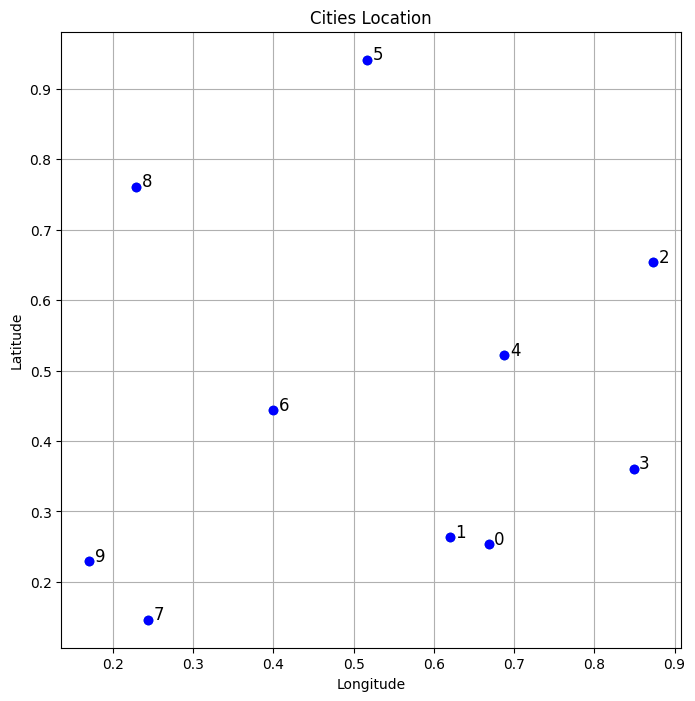

In [ ]:
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt


drive.mount('/content/drive')

# Animal attributes: Each row contains the attributes of one animal
file_path_cities = '/content/drive/MyDrive/DD2437_Lab2_data/cities.dat'

# Read the file, preprocess it to remove semicolons, and load it into numpy
with open(file_path_cities, 'r') as file:
    lines = file.readlines()

# Remove semicolons and write the cleaned data to a list (Also ignores the comments in the beginning)
cleaned_lines = [line.replace(';', '') for line in lines if not line.startswith('%')]

# Convert the cleaned lines to a numpy array
cities = np.genfromtxt(cleaned_lines, delimiter=',')
print(f'Cities location shape: {cities.shape}')  # Shape (10, 2)
print(f'Cities location: {cities}')

shuffled_indices = np.random.permutation(cities.shape[0])
cities = cities[shuffled_indices]

for i in range(cities.shape[0]):
  print(f"Shuffled city {i}: ", cities[i])

plt.figure(figsize=(8, 8))
plt.scatter(cities[:, 0], cities[:, 1], color='blue', label='Cities', zorder=5)
# Annotate each city with its index and offset the labels to avoid overlap
for i, (x, y) in enumerate(cities):
  plt.text(x + 0.02, y, f'{i}', fontsize=12, ha='right', color='black')

plt.grid(True)
plt.scatter(cities[:, 0], cities[:, 1])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cities Location')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to calculate Euclidean distance
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

# Circular distance for neurons (handles wrap-around for closed-loop)
def circular_distance(a, b, n_neurons):
    return min(abs(a - b), n_neurons - abs(a - b))

# Initialize the SOM class
class SOM_TSP:
    def __init__(self, n_neurons, n_iterations, learning_rate, city_coords, plot_interval=100):
        self.n_neurons = n_neurons                # Number of neurons (now equal to the number of cities)
        self.n_iterations = n_iterations          # Number of iterations for training
        self.learning_rate = learning_rate        # Initial learning rate
        self.city_coords = city_coords            # Coordinates of the cities
        self.n_cities = city_coords.shape[0]      # Number of cities
        self.neurons = self.initialize_neurons()  # Initialize neuron positions
        self.plot_interval = plot_interval        # Interval at which to plot progress

    # Initialize neurons in a circular pattern
    def initialize_neurons(self):
        # Initialize the neurons in a circle around the mean of city coordinates
        theta = np.linspace(0, 2 * np.pi, self.n_neurons, endpoint=False)
        x_mean, y_mean = np.mean(self.city_coords, axis=0)  # Center of the circle
        radius = np.mean(np.ptp(self.city_coords, axis=0)) / 2  # Set a suitable radius based on city spread
        x = x_mean + radius * np.cos(theta)
        y = y_mean + radius * np.sin(theta)
        return np.array([x, y]).T  # Shape: (n_neurons, 2)

    # Find the Best Matching Unit (BMU)
    def find_bmu(self, city):
        distances = np.linalg.norm(self.neurons - city, axis=1)
        return np.argmin(distances)

    # Custom sigma decay: from 2 neighbors -> 1 neighbor -> 0 neighbors (BMU only)
    def calculate_sigma(self, iteration):
        total_phases = 3
        phase_length = self.n_iterations // total_phases

        if iteration < phase_length:
            return 2  # First phase: 2 neighbors
        elif iteration < 2 * phase_length:
            return 1  # Second phase: 1 neighbor
        else:
            return 0  # Third phase: BMU only

    # Update the neuron weights with circular distance
    def update_weights(self, bmu_idx, city, iteration):
        lr = self.learning_rate * np.exp(-iteration / self.n_iterations)  # Decay learning rate
        sigma = self.calculate_sigma(iteration)  # Custom sigma based on iteration

        for i, neuron in enumerate(self.neurons):
            distance = circular_distance(bmu_idx, i, self.n_neurons)  # Use circular distance
            if distance <= sigma:  # Neighborhood size dynamically adjusted
                influence = np.exp(-distance**2 / (2 * sigma**2)) if sigma > 0 else 1  # Influence reduces over distance
                self.neurons[i] += lr * influence * (city - neuron)

    # Train the SOM and plot the route over epochs
    def train(self):
        for iteration in range(self.n_iterations):
            city_idx = np.random.randint(self.n_cities)  # Randomly pick a city
            city = self.city_coords[city_idx]
            bmu_idx = self.find_bmu(city)                # Find the BMU
            self.update_weights(bmu_idx, city, iteration)  # Update neuron positions

            # Plot at regular intervals
            if iteration % self.plot_interval == 0 or iteration == self.n_iterations - 1:
                self.plot_map(iteration)

    # Plot the current state of the neurons and cities
    def plot_map(self, iteration=None):
        plt.figure(figsize=(6, 6))
        plt.scatter(self.city_coords[:, 0], self.city_coords[:, 1], c='blue', label='Cities')
        plt.plot(np.append(self.neurons[:, 0], self.neurons[0, 0]),
                 np.append(self.neurons[:, 1], self.neurons[0, 1]), marker='o', c='red', label='Neurons (Route)', markerfacecolor='none')
        for i, city in enumerate(self.city_coords):
            plt.text(city[0], city[1], f'{i}', fontsize=12)
        if iteration is not None:
            plt.title(f"Iteration {iteration}")
        plt.legend()
        plt.show()



10


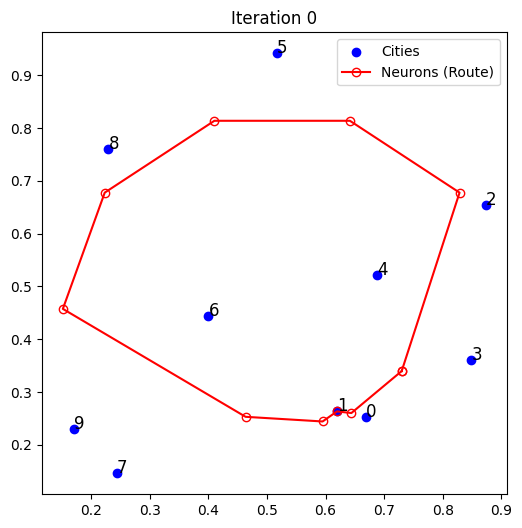

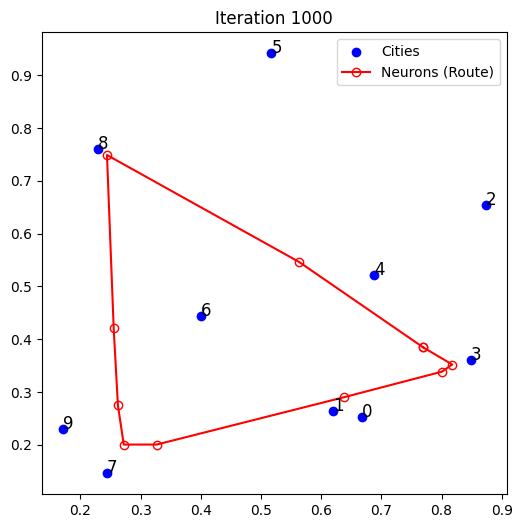

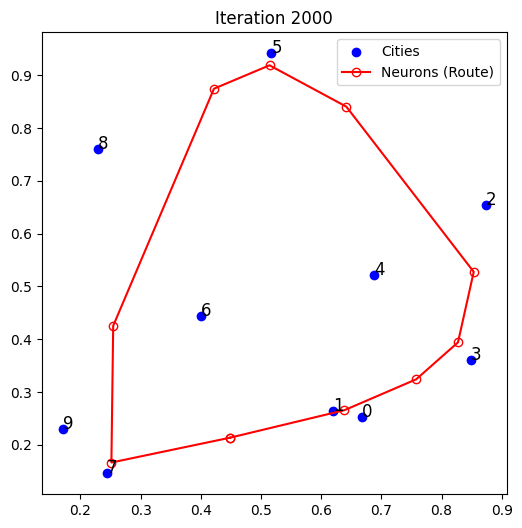

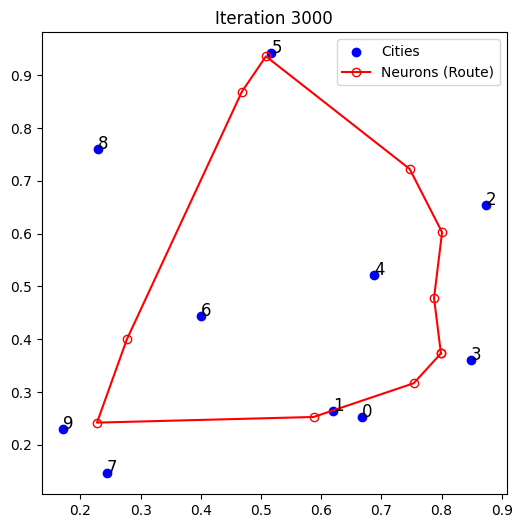

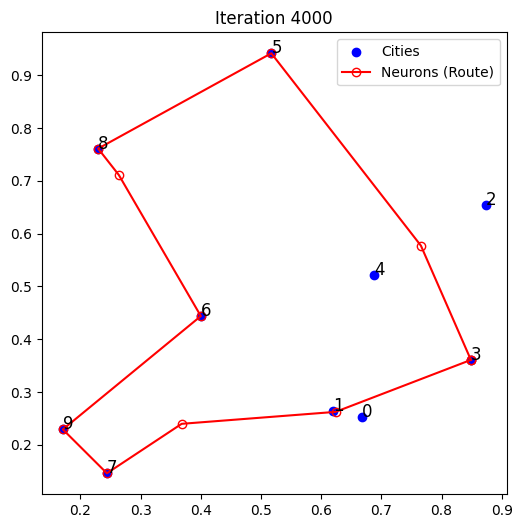

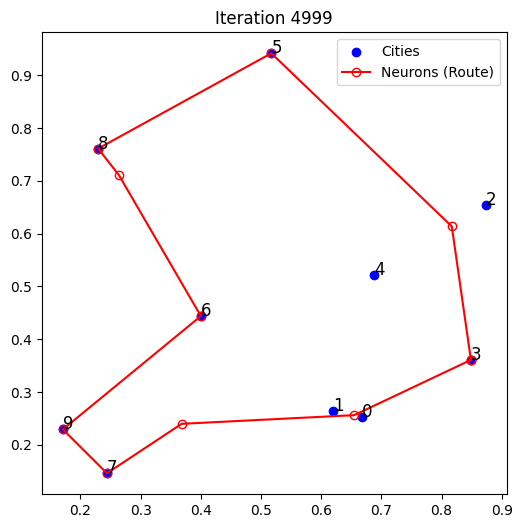

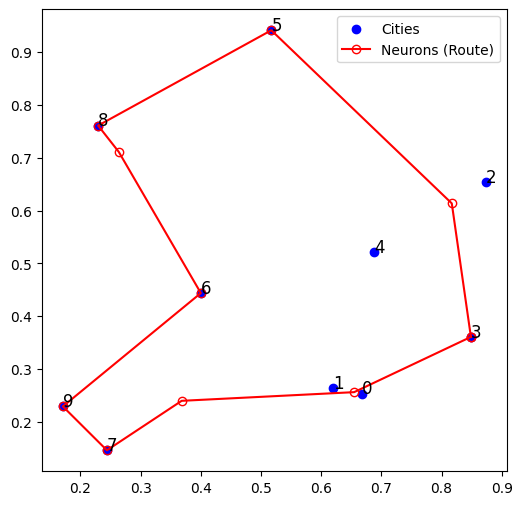

In [ ]:
# Hyperparameters
n_neurons = cities.shape[0]  # Now equal to the number of cities
print(cities.shape[0])
n_iterations = 5000  #
learning_rate = 1

plot_interval = 1000

city_coords = cities

# Initialize and train the SOM
som_tsp = SOM_TSP(n_neurons, n_iterations, learning_rate, city_coords, plot_interval)
som_tsp.train()

# Plot the final result
som_tsp.plot_map()


# First try 4.2 (wrong)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class SOM_TSP:
    def __init__(self, num_nodes, input_dim, learning_rate=0.1, sigma=2, num_epochs=1000):
        """
        Initializes the SOM with a 1D circular topology.

        :param num_nodes: Number of nodes (size of 1D output)
        :param input_dim: Dimension of each input vector (2 for TSP)
        :param learning_rate: Initial learning rate
        :param sigma: Initial neighborhood radius (defaults to num_nodes / 2)
        :param num_epochs: Number of training epochs
        """
        self.num_nodes = num_nodes
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.num_epochs = num_epochs

        # Initialize weights for SOM nodes with random positions in the 2D plane
        self.weights = np.random.rand(num_nodes, input_dim)

        # Time constant for neighborhood size decay
        self.time_constant = num_epochs / np.log(self.sigma)

    def _circular_distance(self, i, j):
        """Compute the circular distance between two nodes in the 1D SOM."""
        return min(abs(i - j), self.num_nodes - abs(i - j))

    def _find_bmu(self, input_vector):
        """Find the Best Matching Unit (BMU) for a given input vector (city)."""
        distances = np.linalg.norm(self.weights - input_vector, axis=1)
        bmu_index = np.argmin(distances)
        return bmu_index

    def _update_weights(self, input_vector, bmu_index, iteration):
        """Update the weights of the BMU and its neighbors."""
        sigma_t = self.sigma * np.exp(-iteration / self.time_constant)
        lr_t = self.learning_rate * np.exp(-iteration / self.num_epochs)

        for i in range(self.num_nodes):
            distance_to_bmu = self._circular_distance(i, bmu_index)

            # Update weights if the node is within the neighborhood radius
            if distance_to_bmu <= sigma_t:
                influence = np.exp(-(distance_to_bmu ** 2) / (2 * sigma_t ** 2))
                self.weights[i, :] += lr_t * influence * (input_vector - self.weights[i, :])

    def train(self, data):
        """Train the SOM on the given data (city coordinates)."""
        for epoch in range(self.num_epochs):
            for input_vector in data:
                bmu_index = self._find_bmu(input_vector)
                self._update_weights(input_vector, bmu_index, epoch)

    def assign_unique_nodes(self, data):
        """
        Ensure each city is assigned to a unique node in the SOM after training.
        """
        node_assignments = {}
        city_order = []

        for city_idx, city in enumerate(data):
            distances = np.linalg.norm(self.weights - city, axis=1)
            sorted_nodes = np.argsort(distances)

            # Assign to the closest available node
            for node_idx in sorted_nodes:
                if node_idx not in node_assignments:
                    node_assignments[node_idx] = city_idx
                    break

        # Sort nodes to create the tour order
        sorted_nodes = sorted(node_assignments.keys())
        for node in sorted_nodes:
            city_order.append(node_assignments[node])

        return city_order

    def get_weights(self):
        """Return the weight matrix (coordinates of nodes)."""
        return self.weights


In [ ]:
def quantization_error(som, data):
  """
  Calculate the quantization error of the SOM.

  :param som: The trained SOM object.
  :param data: The input data (city coordinates).
  :return: Quantization error.
  """
  total_error = 0
  for input_vector in data:
      bmu_index = som._find_bmu(input_vector)
      bmu_weight = som.weights[bmu_index]
      total_error += np.linalg.norm(input_vector - bmu_weight)
  return total_error / len(data)



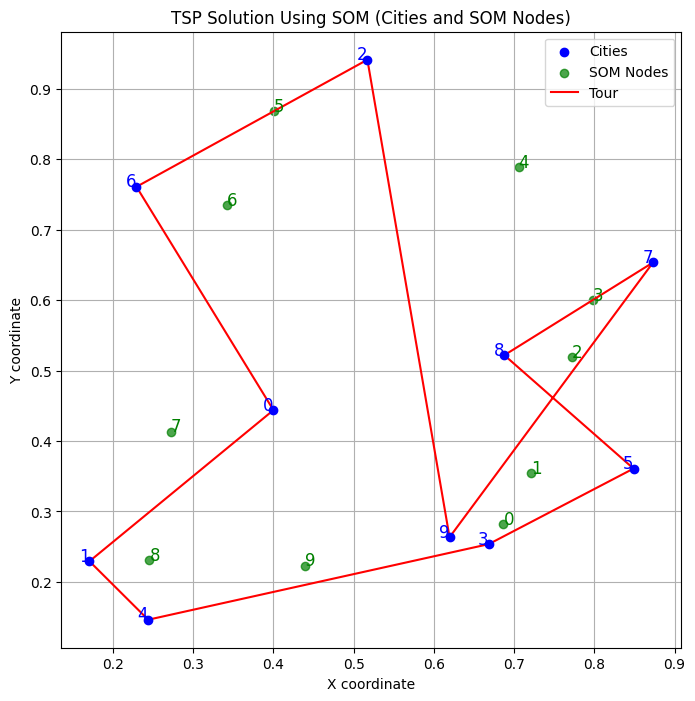

City assignments to SOM nodes:
City 3 ([0.6683 0.2536]) assigned to node 0
City 5 ([0.8488 0.3609]) assigned to node 1
City 8 ([0.6878 0.5219]) assigned to node 2
City 7 ([0.8732 0.6536]) assigned to node 3
City 9 ([0.6195 0.2634]) assigned to node 4
City 2 ([0.5171 0.9414]) assigned to node 5
City 6 ([0.2293 0.761 ]) assigned to node 6
City 0 ([0.4    0.4439]) assigned to node 7
City 1 ([0.1707 0.2293]) assigned to node 8
City 4 ([0.2439 0.1463]) assigned to node 9
Total length of the tour: 3.3785
Quantization error: 0.09523564211108998


In [ ]:
# Initialize and train SOM for TSP
som_tsp = SOM_TSP(num_nodes=10, input_dim=2, learning_rate=0.5, sigma=5, num_epochs=2000)
som_tsp.train(cities)

# Assign each city to a unique node in the SOM after training
city_order = som_tsp.assign_unique_nodes(cities)

# Create the tour based on the assigned city order
tour_cities = cities[city_order]

# Append the first city at the end to close the circular tour
tour_cities = np.vstack([tour_cities, tour_cities[0]])


# Plotting the cities and the tour
plt.figure(figsize=(8, 8))

# Plot the cities (blue) and SOM nodes (green)
plt.scatter(cities[:, 0], cities[:, 1], color='blue', label='Cities', zorder=5)
plt.scatter(som_tsp.weights[:, 0], som_tsp.weights[:, 1], color='green', label='SOM Nodes', alpha=0.7)

# Plot the tour by connecting the cities in the assigned order
plt.plot(tour_cities[:, 0], tour_cities[:, 1], color='red', linestyle='-', label='Tour')

# Annotate each city with its index and avoid overlap
for i, (x, y) in enumerate(cities):
    plt.text(x, y, f'{i}', fontsize=12, ha='right', color='blue')

# Annotate each node with its index and avoid overlap
for i, (x, y) in enumerate(som_tsp.weights):
    plt.text(x, y, f'{i}', fontsize=12, ha='left', color='green')

plt.title('TSP Solution Using SOM (Cities and SOM Nodes)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True)
plt.show()

# Print the mapping of cities to nodes for debugging
print("City assignments to SOM nodes:")
for node_idx, city_idx in enumerate(city_order):
    print(f'City {city_idx} ({cities[city_idx]}) assigned to node {node_idx}')



# Calculate and print the total length of the tour
def tour_length(tour):
    length = 0
    for i in range(len(tour) - 1):
        length += np.linalg.norm(tour[i] - tour[i + 1])
    return length

length = tour_length(tour_cities)
print(f'Total length of the tour: {length:.4f}')

qe = quantization_error(som_tsp, cities)
print(f'Quantization error: {qe}')


# 4.3 Data Clustering: Votes of MPs

In [ ]:
import numpy as np
import pandas as pd

drive.mount('/content/drive')

# Comma separated 0, 0.5 and 1
file_path_votes = '/content/drive/MyDrive/DD2437_Lab2_data/votes.dat'
file_path_party = '/content/drive/MyDrive/DD2437_Lab2_data/mpparty.dat'
file_path_sex = '/content/drive/MyDrive/DD2437_Lab2_data/mpsex.dat'
file_path_district = '/content/drive/MyDrive/DD2437_Lab2_data/mpdistrict.dat'
file_path_names = '/content/drive/MyDrive/DD2437_Lab2_data/mpnames.txt'


# Load the votes data (349 MPs, 31 votes)
votes = np.genfromtxt(file_path_votes, delimiter=',').reshape(349, 31)

# Load the names (one name per row)
with open(file_path_names, 'r', encoding='ISO-8859-1') as file:
    names = [line.strip() for line in file.readlines()]

# Load the gender data (0s and 1s)
with open(file_path_sex, 'r') as file:
    genders = []
    for line in file:
        line = line.strip()  # Remove leading/trailing whitespace
        if line and line[0].isdigit():  # Only process lines that start with a digit
            genders.append(int(line))  # Convert to integer and add to the list
genders = np.array(genders)

# Load the district data (numbers between 1 and 29)
districts = np.genfromtxt(file_path_district, delimiter=',').astype(int)

# Load the party data (numbers between 0 and 7)
with open(file_path_party, 'r') as file:
    parties = []
    for line in file:
        line = line.strip()  # Remove leading/trailing whitespace
        if line and line[0].isdigit():  # Only process lines that start with a digit
            parties.append(int(line))  # Convert to integer and add to the list
parties = np.array(parties)

# Verify that all data have the same length (349)
#assert votes.shape[0] == len(names) == genders.shape[0] == districts.shape[0] == parties.shape[0], "Data mismatch in length"

# Create a DataFrame for easy manipulation
mp_data = pd.DataFrame({
    'Name': names,
    'Gender': genders,       # 0 or 1 (0 = men, 1 = women)
    'District': districts,   # 1 to 29
    'Party': parties,        # 0 to 7
    'Votes': list(votes)     # Each row will be a list of 31 votes
})

# Display the first few rows
print(mp_data.head())
print("Votes Shape: ", votes.shape)
print("Genders Shape: ", genders.shape)
print("Districts Shape: ", districts.shape)
print("Parties Shape: ", parties.shape)
print("Names length: ", len(names))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                Name  Gender  District  Party  \
0  Skårman Carl-Erik       0         1      1   
1    Romanus Gabriel       0         1      2   
2    Odenberg Mikael       0         1      1   
3    Järrel Henrik S       0         1      1   
4    Lindgren Sylvia       1         1      3   

                                               Votes  
0  [0.0, 1.0, 0.0, 0.5, 0.0, 0.0, 1.0, 0.5, 0.0, ...  
1  [0.0, 1.0, 1.0, 0.5, 0.0, 0.0, 1.0, 0.5, 0.0, ...  
2  [0.0, 1.0, 0.0, 0.5, 0.0, 0.0, 1.0, 0.5, 0.0, ...  
3  [0.0, 1.0, 0.0, 0.5, 0.0, 0.0, 1.0, 0.5, 0.0, ...  
4  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, ...  
Votes Shape:  (349, 31)
Genders Shape:  (349,)
Districts Shape:  (349,)
Parties Shape:  (349,)
Names length:  349


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.patches as patches

# SOM Class Definition
class SOM:
    def __init__(self, grid_size, input_dim, learning_rate=0.5, sigma=1.0, num_iterations=100):
        self.grid_size = grid_size
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.num_iterations = num_iterations
        self.weights = np.random.rand(grid_size[0], grid_size[1], input_dim)  # Initialize weights randomly
        self.bmus = []  # To store Best Matching Unit for each MP

    def train(self, data):
        for iteration in range(self.num_iterations):
            lr = self.learning_rate * np.exp(-iteration / self.num_iterations)
            sigma_decay = self.sigma * np.exp(-iteration / self.num_iterations)

            # Randomly select one MP's vote vector
            sample_idx = np.random.randint(0, data.shape[0])
            sample = data[sample_idx]

            # Find the Best Matching Unit (BMU)
            bmu_idx = self.find_bmu(sample)

            # Update weights of the BMU and its neighbors
            self.update_weights(bmu_idx, sample, lr, sigma_decay)

            if iteration == self.num_iterations - 1:  # On last iteration, record the BMUs for all MPs
                self.bmus = [self.find_bmu(mp) for mp in data]  # Save BMUs for each MP

    def find_bmu(self, sample):
        distances = np.linalg.norm(self.weights - sample, axis=2)
        return np.unravel_index(np.argmin(distances), self.weights.shape[:2])

    def update_weights(self, bmu_idx, sample, lr, sigma):
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                dist_to_bmu = np.linalg.norm(np.array([x, y]) - np.array(bmu_idx))
                if dist_to_bmu < sigma:
                    influence = np.exp(-(dist_to_bmu ** 2) / (2 * (sigma ** 2)))
                    self.weights[x, y, :] += lr * influence * (sample - self.weights[x, y, :])

    # def plot_map_with_attributes(self, df):
    #     # Plot gender, district, and party mappings
    #     fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    #     # Gender plot
    #     for bmu, gender in zip(self.bmus, df['Gender']):
    #         color = 'red' if gender == 0 else 'blue'  # Assuming 0 = Male, 1 = Female
    #         ax[0].scatter(bmu[0], bmu[1], c=color, marker='o')
    #     ax[0].set_title("Gender: Red = Male, Blue = Female")

    #     # District plot
    #     district_labels = np.unique(df['District'])
    #     district_colors = plt.cm.get_cmap('tab10', len(district_labels))
    #     for bmu, district in zip(self.bmus, df['District']):
    #         color = district_colors(district_labels.tolist().index(district))
    #         ax[1].scatter(bmu[0], bmu[1], c=[color], marker='o')
    #     ax[1].set_title("Districts (Different colors)")

    #     # Party plot
    #     party_labels = np.unique(df['Party'])
    #     party_colors = plt.cm.get_cmap('tab20', len(party_labels))
    #     for bmu, party in zip(self.bmus, df['Party']):
    #         color = party_colors(party_labels.tolist().index(party))
    #         ax[2].scatter(bmu[0], bmu[1], c=[color], marker='o')
    #     ax[2].set_title("Parties (Different colors)")

    #     plt.show()

    # Unsupervised SOM grid (no labels or color-coding)
    def plot_unsupervised_grid(self, names):
        plt.figure(figsize=(10, 10))

        # Dictionary to store MPs in each grid square (for handling multiple MPs in the same square)
        square_to_mps = defaultdict(list)

        # Group MPs by their BMU (Best Matching Unit)
        for i, bmu in enumerate(self.bmus):
            square_to_mps[bmu].append(names[i])  # Group MPs by BMU

        # Find the maximum number of MPs in any square for normalization
        max_mps = max(len(mps) for mps in square_to_mps.values())

        # Create the 2D grid (with greyscale based on number of MPs)
        for bmu, mps in square_to_mps.items():
          # Normalize the count of MPs to the range [0, 1] for greyscale
          normalized_value = len(mps) / max_mps

          # Apply a factor to darken the greyscale (e.g., 0.7 to keep it darker)
          darkening_factor = 0.7
          grey_color = str(1 - (normalized_value * darkening_factor))  # Invert and darken the scale

          # Draw a square for each BMU (cell in the grid) with the adjusted greyscale value
          plt.gca().add_patch(plt.Rectangle((bmu[0], bmu[1]), 1, 1, edgecolor='black', facecolor=grey_color))

          # Display the number of MPs in the square
          plt.text(bmu[0] + 0.5, bmu[1] + 0.5, f'{len(mps)} MPs', color='black', ha='center', va='center', fontsize=8)

        # Adjust plot limits
        plt.xlim([0, self.grid_size[0]])
        plt.ylim([0, self.grid_size[1]])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Unsupervised SOM Grid (Greyscale by MPs Count)")
        plt.show()

    def plot_grid_with_parties(self, parties, party_labels, party_color_map):
        plt.figure(figsize=(10, 10))

        # Dictionary to store MPs in each grid square
        square_to_mps = defaultdict(list)

        # Group MPs by their BMU (Best Matching Unit)
        for i, bmu in enumerate(self.bmus):
            square_to_mps[bmu].append(parties[i])

        # Create the 2D grid (color-coding based on party)
        for bmu, mps in square_to_mps.items():
            # Count the occurrences of each party in the square
            party_counts = defaultdict(int)
            for party in mps:
                party_counts[party] += 1

            # Sort parties by their counts in descending order
            sorted_parties = sorted(party_counts.items(), key=lambda x: x[1], reverse=True)

            if len(sorted_parties) > 1 and sorted_parties[0][1] == sorted_parties[1][1]:
                # Tie between the two biggest parties, split the square half and half
                first_party, second_party = sorted_parties[0][0], sorted_parties[1][0]
                first_color = party_color_map[first_party]
                second_color = party_color_map[second_party]

                # Draw the first half of the square (left half)
                plt.gca().add_patch(patches.Polygon([[bmu[0], bmu[1]], [bmu[0] + 1, bmu[1]], [bmu[0], bmu[1] + 1]],
                                                    edgecolor='black', facecolor=first_color))

                # Draw the second half of the square (right half)
                plt.gca().add_patch(patches.Polygon([[bmu[0] + 1, bmu[1]], [bmu[0] + 1, bmu[1] + 1], [bmu[0], bmu[1] + 1]],
                                                    edgecolor='black', facecolor=second_color))
            else:
                # No tie, color the square with the dominant party's color
                dominant_party = sorted_parties[0][0]
                dominant_color = party_color_map[dominant_party]

                # Draw a square for each BMU (cell in the grid)
                plt.gca().add_patch(plt.Rectangle((bmu[0], bmu[1]), 1, 1, edgecolor='black', facecolor=dominant_color))

            # Display the number of MPs from each party in this square
            text = '\n'.join([f'{party_labels[p]}: {count}' for p, count in party_counts.items()])
            plt.text(bmu[0] + 0.5, bmu[1] + 0.5, text, color='black', ha='center', va='center', fontsize=8)

        # Adjust plot limits
        plt.xlim([0, self.grid_size[0]])
        plt.ylim([0, self.grid_size[1]])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("SOM Grid Colored by Party Affiliation")
        plt.show()


    def plot_grid_with_gender(self, genders):
        plt.figure(figsize=(10, 10))

        # Dictionary to store MPs in each grid square
        square_to_mps = defaultdict(list)

        # Group MPs by their BMU (Best Matching Unit)
        for i, bmu in enumerate(self.bmus):
            square_to_mps[bmu].append(genders[i])

        # Create the 2D grid (color-coding based on gender)
        for bmu, mps in square_to_mps.items():
            # Count the occurrences of each gender in the square
            male_count = sum(1 for gender in mps if gender == 0)  # Assuming 0 = male
            female_count = len(mps) - male_count  # Assuming 1 = female

            if male_count == female_count and male_count > 0:
                # If there is a tie between males and females, split the square in half
                # First half (left triangle) for males (blue)
                plt.gca().add_patch(patches.Polygon([[bmu[0], bmu[1]], [bmu[0] + 1, bmu[1]], [bmu[0], bmu[1] + 1]],
                                                    edgecolor='black', facecolor='lightgreen'))

                # Second half (right triangle) for females (orange)
                plt.gca().add_patch(patches.Polygon([[bmu[0] + 1, bmu[1]], [bmu[0] + 1, bmu[1] + 1], [bmu[0], bmu[1] + 1]],
                                                    edgecolor='black', facecolor='orange'))
            else:
                # No tie, color the square based on the dominant gender
                color = 'lightgreen' if male_count > female_count else 'orange'

                # Draw a square for each BMU (cell in the grid)
                plt.gca().add_patch(plt.Rectangle((bmu[0], bmu[1]), 1, 1, edgecolor='black', facecolor=color))

            # Display the number of males and females in the square
            text = f'M: {male_count}\nF: {female_count}'
            plt.text(bmu[0] + 0.5, bmu[1] + 0.5, text, color='black', ha='center', va='center', fontsize=8)

        # Adjust plot limits
        plt.xlim([0, self.grid_size[0]])
        plt.ylim([0, self.grid_size[1]])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("SOM Grid with Gender Overlay (Blue = Male, Orange = Female)")
        plt.show()

    def plot_grid_with_districts(self, districts):
      plt.figure(figsize=(10, 10))

      # Dictionary to store MPs in each grid square
      square_to_mps = defaultdict(list)

      # Group MPs by their BMU (Best Matching Unit)
      for i, bmu in enumerate(self.bmus):
          square_to_mps[bmu].append(districts[i])  # Store districts

      # Find the maximum number of unique districts in any square for normalization
      max_districts = max(len(set(mps)) for mps in square_to_mps.values())

      # Create the 2D grid (with greyscale based on the number of unique districts)
      for bmu, mps in square_to_mps.items():
          # Count the occurrences of each district in the square
          district_counts = defaultdict(int)
          for district in mps:
              district_counts[district] += 1

          # Find the district with the most MPs (biggest district in the square)
          biggest_district = max(district_counts, key=district_counts.get)

          # Normalize the count of unique districts to the range [0, 1] for greyscale
          num_unique_districts = len(set(mps))
          normalized_value = num_unique_districts / max_districts if max_districts > 0 else 0

          # Apply a factor to darken the greyscale
          darkening_factor = 0.7  # Adjust to control darkness
          grey_color = str(1 - (normalized_value * darkening_factor))  # Invert and apply darkening

          # Draw a square for each BMU (cell in the grid) with the adjusted greyscale value
          plt.gca().add_patch(plt.Rectangle((bmu[0], bmu[1]), 1, 1, edgecolor='black', facecolor=grey_color))

          # Display the biggest district in the square
          text = f'D{biggest_district}'
          plt.text(bmu[0] + 0.5, bmu[1] + 0.5, text, color='black', ha='center', va='center', fontsize=8)

      # Adjust plot limits
      plt.xlim([0, self.grid_size[0]])
      plt.ylim([0, self.grid_size[1]])
      plt.gca().set_aspect('equal', adjustable='box')
      plt.title("SOM Grid with Biggest District and Greyscale by Number of Unique Districts")
      plt.show()

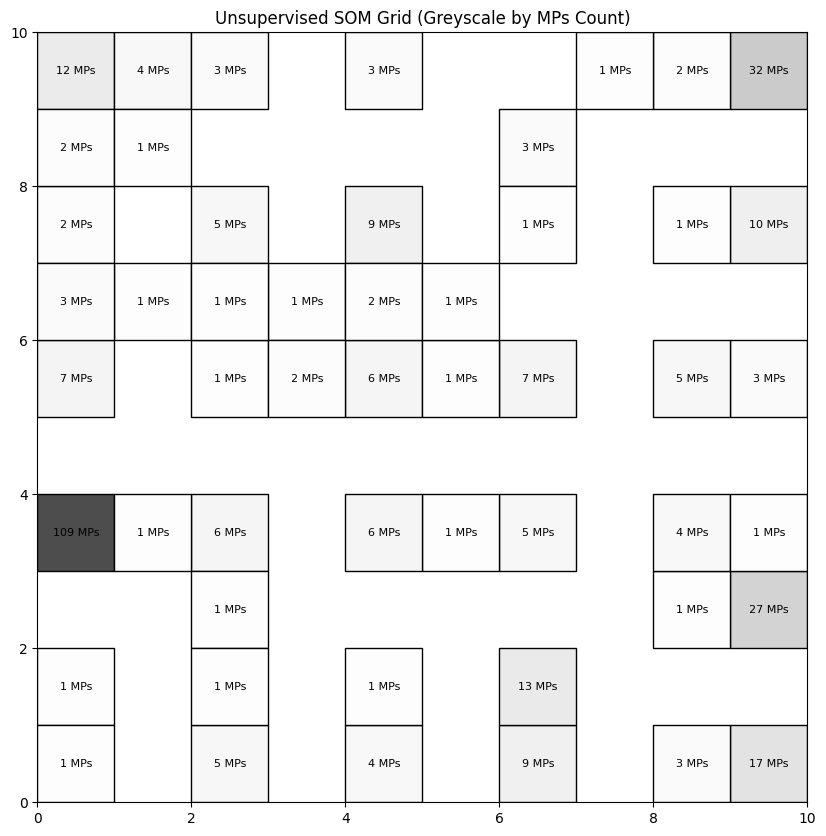

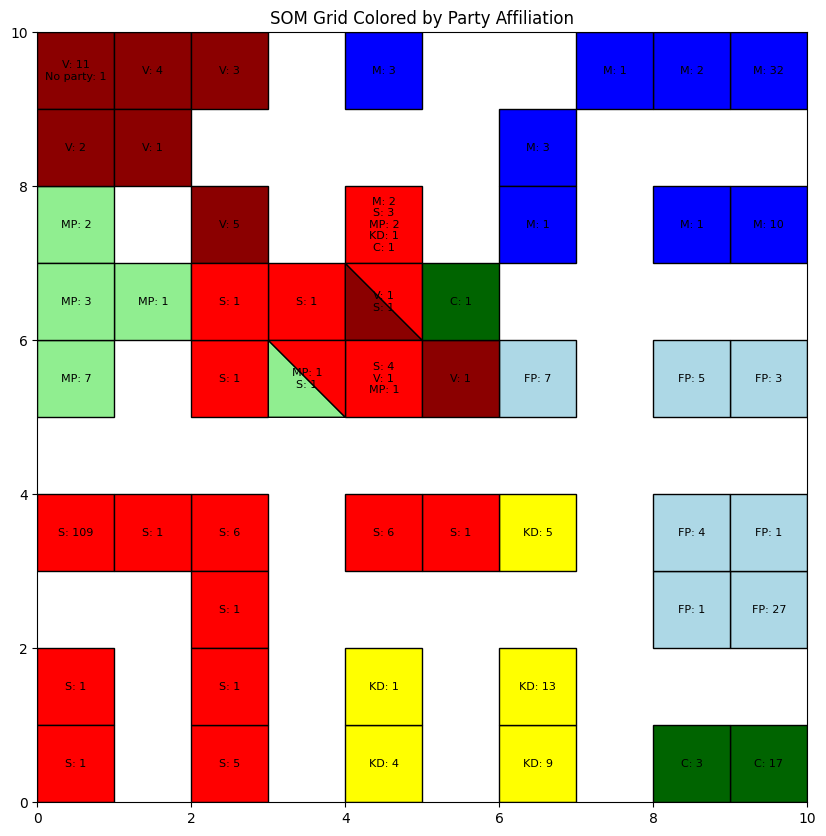

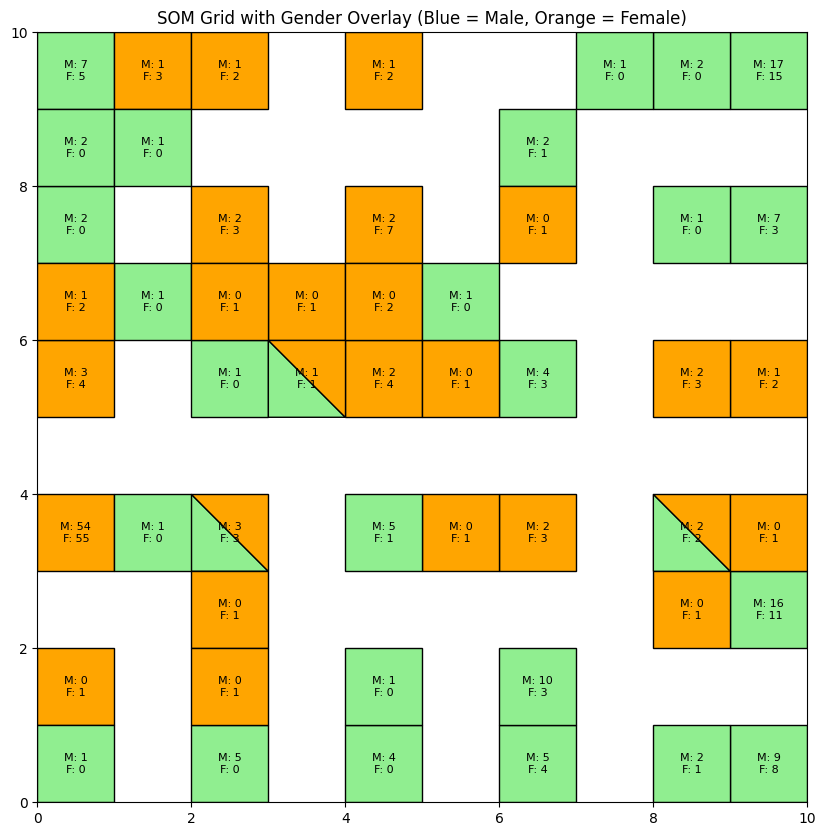

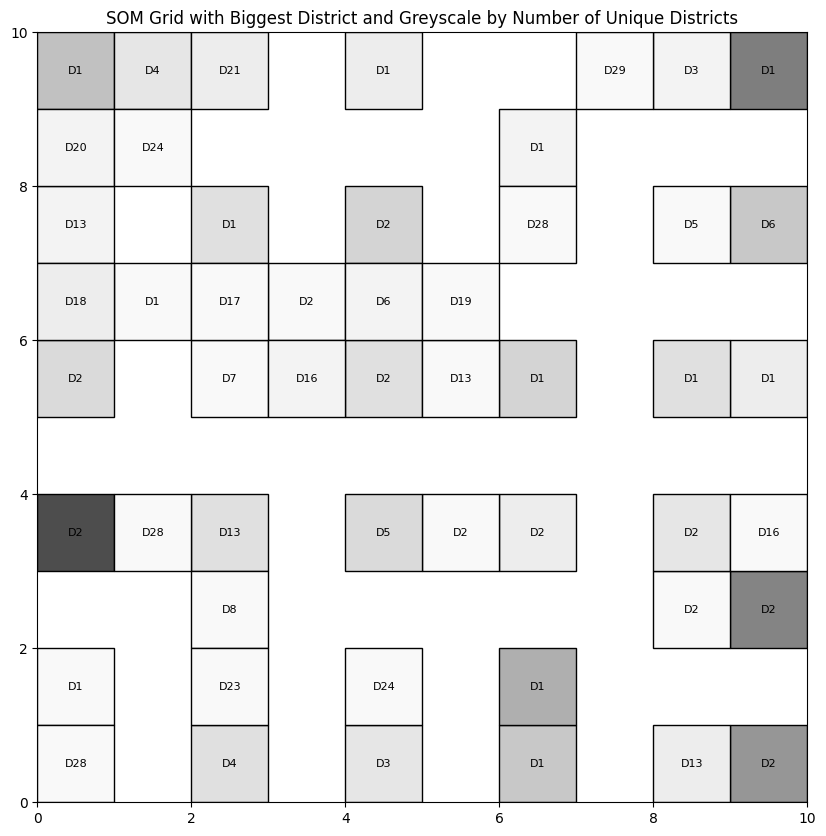

In [ ]:
# Initialize and train the SOM with 10x10 grid and 31-dimensional input space (votes data)
som = SOM(grid_size=(10, 10), input_dim=31, learning_rate=0.5, sigma=5, num_iterations=10000)
som.train(np.array(mp_data['Votes'].tolist()))  # Convert list of votes back to a numpy array for training

# Plot the results with respect to gender, district, and party
#som.plot_map_with_attributes(mp_data)

# Party color mapping based on your specification
party_color_map = {
    0: 'grey',      # No party
    1: 'blue',      # M
    2: 'lightblue', # FP
    3: 'red',       # S
    4: 'darkred',   # V
    5: 'lightgreen',# MP
    6: 'yellow',    # KD
    7: 'darkgreen'  # C
}

party_labels = {
    0: 'No party',      # No party
    1: 'M',      # M
    2: 'FP', # FP
    3: 'S',       # S
    4: 'V',   # V
    5: 'MP',# MP
    6: 'KD',    # KD
    7: 'C'
}

# Assign colors to each MP based on their party
#party_colors = [party_color_map[p] for p in parties]

# Plot different views of the SOM
som.plot_unsupervised_grid(names)          # Unsupervised grid with names
som.plot_grid_with_parties(parties, party_labels, party_color_map)  # Overlay party affiliation
som.plot_grid_with_gender(genders)         # Overlay gender
som.plot_grid_with_districts(districts)     # Overlay district